In [1]:
def clearall():
    all = [var for var in globals() if var[0] != "_"]
    for var in all:
        del globals()[var]
clearall()

# https://www.datacamp.com/community/tutorials/introduction-factor-analysis

In [2]:
############################
######## LIBRAIRIES ########
############################
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from pandas.plotting import lag_plot
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.vector_ar.vecm import coint_johansen as johasen
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import numpy as np
%matplotlib inline
plt.style.use('seaborn')
os.system('say " שלום, אדוני היקר . אני כאן כדי לשרת אותך . אני gaulèm . אנחנו הולכים לעשות הרבה כסף. אוי לי אם לא אצליח במשימה שלי"')

0

In [3]:
############################
######## FONCTIONS ########
###########################
def ols(model,results,residuals):
    jb = sm.stats.stattools.jarque_bera(residuals)[0]
    p_value = sm.stats.stattools.jarque_bera(residuals)[1]
    skew = round(sm.stats.stattools.robust_skewness(residuals)[0],4)
    kurtosis = round(sm.stats.stattools.robust_kurtosis(residuals)[0],4)
    print (name+' : ',results.summary())
    durbinwatson = sm.stats.stattools.durbin_watson(residuals, axis=0)
    print (name+' : ',durbinwatson)
    return(jb,p_value,skew,kurtosis,durbinwatson)

def ols_diff(diff):
    model_diff = sm.OLS(diff[1:],df.index[1:])
    results_diff = model_diff.fit()
    residuals_diff = results_diff.resid
    summary_diff = results_diff.summary()

    jb_diff = sm.stats.stattools.jarque_bera(residuals_diff)[0]
    p_value_diff = sm.stats.stattools.jarque_bera(residuals_diff)[1]
    skew_diff = round(sm.stats.stattools.robust_skewness(residuals_diff)[0],4)
    kurtosis_diff = round(sm.stats.stattools.robust_kurtosis(residuals_diff)[0],4)
    print (name+' : ',results_diff.summary())
    durbinwatson_diff = sm.stats.stattools.durbin_watson(residuals_diff, axis=0)
    print (name+' : ',durbinwatson_diff)
    return(jb_diff,p_value_diff,skew_diff,kurtosis_diff,durbinwatson_diff)

def jarque_berra(df):
    print(Fore.LIGHTBLUE_EX,'\nTEST DE NORMALITE : JARQUE-BERA '+name,Style.RESET_ALL)
    if p_value <= 0.05:
        print("Puisque la p-value (",round(p_value,4),") de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on ",\
        "refuse l’hypothèse de la normalité de la série ")
        print(Fore.GREEN,'TEST JARQUE-BERRA VALIDE',Style.RESET_ALL)
    else:
        print("Puisque la p-value (",round(p_value,4),") de la statistique de Jarque-Bera est supérieure au seuil de signification de 5%",\
        " donc on refusel’hypothèse de la normalité de la série ")
        print(Fore.RED,"TEST JARQUE-BERA ECHOUE",Style.RESET_ALL)
    return()

def skewness(df):
    print(Fore.LIGHTBLUE_EX,"\nTEST D'ASSYMETRIE: SKEWNESS "+name,Style.RESET_ALL)
    if skew < -0.1 or skew > 0.1:
        print("Puisque le skewness (",round(skew,4),") de la statistiqest éloigné de 0, donc on valide en niveau 1 une distribution NON NORMALE")
        print(Fore.GREEN,'TEST SKEWNESS VALIDE',Style.RESET_ALL)
    else:
        print(Fore.RED,'/!\ ATTENTION SUPISCION DE NORMALITE /!\ ')
        print(Fore.RED,"TEST SKEWNESS ECHOUE",Style.RESET_ALL)
    return()

def kurtos(df):
    print(Fore.LIGHTBLUE_EX,"\nTEST D'ASSYMETRIE: KURTOSIS "+name,Style.RESET_ALL)
    if kurtosis > -3.1 or kurtosis < 3.1:
        print("Puisque le skewness (",round(kurtosis,4),") de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE")
        print(Fore.GREEN,'TEST DE KURTOSIS VALIDE',Style.RESET_ALL)
    else:
        print(Fore.RED,'/!\ ATTENTION SUPISCION DE NORMALITE /!\ ')
        print(Fore.RED,"TEST KURTOSIS ECHOUE",Style.RESET_ALL)
    return()
def autocor(df):
    print(Fore.LIGHTBLUE_EX,"\nCORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE "+name,Style.RESET_ALL)
    plot_acf(df['Close'])
    plot_pacf(df['Close'], lags=50)
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(df['Close'])
    QSTAT = list(sm.tsa.stattools.acf(df['Close'],qstat=True,fft=False)[1])
    QSTAT.append(df.iloc[-1]['Close'])
    PROB = list(sm.tsa.stattools.acf(df['Close'],qstat=True,alpha=0.05,fft=False)[3])
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    print(name+' : ',autocorell.head())
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Il apparait donc clairement que la série n'est pas un bruit blanc")
        print(Fore.GREEN,'TEST AUTOCORRELATION VALIDE',Style.RESET_ALL)
    else:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Nous ne pouvons pas déterminer que la série n'est pas un bruit blanc")
    return()

def autocor_diff(diff):
    print(Fore.LIGHTBLUE_EX,"\nCORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE EUR/USD EN PREMIERE DIFFERENCE",Style.RESET_ALL)
    plot_acf(diff)
    plot_pacf(diff, lags=50)
    autocorell = pd.DataFrame()
    autocorell['ACF'] = sm.tsa.stattools.acf(diff,qstat=True,fft=False)[0]
    autocorell['PACF'] = sm.tsa.stattools.pacf(diff)
    QSTAT = list(sm.tsa.stattools.acf(diff,qstat=True)[1],fft=False)
    QSTAT.append(0)
    PROB = list(sm.tsa.stattools.acf(diff,qstat=True,alpha=0.05)[3],fft=False)
    PROB.append(0.5)
    autocorell['QSTAT'] = QSTAT
    autocorell['PROB'] = PROB
    print(name+' : ',autocorell.head())
    index = 0
    for i in range(len(autocorell)-1):
        if autocorell.iloc[i]['PACF']>autocorell.iloc[i]['PROB']+0.1:
            index += 1
    if index >= 1:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Il apparait donc clairement que la série n'est pas un bruit blanc")
        print(Fore.GREEN,'TEST AUTOCORRELATION VALIDE',Style.RESET_ALL)
        print("D’après le corrélogramme de la série ‘EURUSD’ en différence première, nous constatons que la première bande associée à la fonction    d’auto-corrélation partielle sort significativement de l’intervalle de confiance représenté par les pointillés, donc nous retenons p = 1 comme nombre de retards pour les régressions des tests ADF")
        p = 1
    else:
        print("L'index de sortie de l'intervalle de confiance à 5% est de",index,". Nous ne pouvons pas déterminer que la série n'est pas un bruit blanc")
    return()

def test_stationarity(timeseries,lag):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for '+name)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test pour la paire : '+name)
    dftest = adfuller(timeseries, autolag=None,maxlag=lag )#'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return(dfoutput)

def test_adf(df):
    print(Fore.BLUE,"\nADF MODELE 3 pour la paire : "+name,Style.RESET_ALL)
    X = df['Close'].values
    result_adf = adfuller(X)
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')

    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05:
        print("La p_value est de ",result_adf[1],"et est bien supérieure à 0.05. On accèpte l'hypothèse nulle Ho. Il n'y a pas de trend significatif")
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    else:
        print(Fore.RED,"TEST ADF => STATIONNAIRE",Style.RESET_ALL)

    print(Fore.BLUE,"\nADF MODELE 2 (LAG)",Style.RESET_ALL)
    X = diff[1:].values
    result_adf = adfuller(X)
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')

    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))

    if result_adf[1] >= 0.05 :
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    elif result_adf[0] >= min([result_adf[4]['1%'],result_adf[4]['5%'],result_adf[4]['10%']]):
        print(Fore.GREEN,'TEST ADF => NON STATIONNAIRE',Style.RESET_ALL)

    else:
        print("La série est stationnaire en intégration d'ordre 1")
        print(Fore.RED,"TEST ADF => STATIONNAIRE",Style.RESET_ALL)
    return()

def isname(pair):
    if pair.equals(eurusd):
        name = 'EUR/USD'
    elif pair.equals(audusd):
        name = 'AUD/USD'
    elif pair.equals(usdchf):
        name = 'USD/CHF'
    elif pair.equals(gbpusd):
        name = 'GBP/USD'
    elif pair.equals(usdjpy):
        name = 'USD/JPY'
    
    return(name)

def revname(name):
    if name == 'EUR/USD':
        pair = eurusd
    elif name == 'AUD/USD':
        pair = audusd
    elif name == 'USD/CHF':
        pair = usdchf
    elif name == 'GBP/USD':
        pair = gbpusd
    elif name == 'USD/JPY':
        pair = usdjpy
        
    return(pair)

In [4]:
eurusd = pd.read_csv('EURUSD.csv')
#eurusd.index = eurusd['Local time']
#eurusd = eurusd.drop(['Local time'],axis=1)
eurusd = eurusd[(eurusd['Local time'] >= '01.06.2011 00:00:00.000 GMT+0200')&(eurusd['Local time'] <= '07.06.2011 13:30:00.000 GMT+0200')]
try:
    eurusd = eurusd.drop(['Unnamed: 0'],axis=1)
except:
    pass

audusd = pd.read_csv('AUDUSD.csv')
#audusd.index = audusd['Local time']
#audusd = audusd.drop(['Local time'],axis=1)
audusd = audusd[(audusd['Local time'] >= '01.06.2011 00:00:00.000 GMT+0200')&(audusd['Local time'] <= '07.06.2011 13:30:00.000 GMT+0200')]
try:
    audusd = audusd.drop(['Unnamed: 0'],axis=1)
except:
    pass

usdchf = pd.read_csv('USDCHF.csv')
#chfusd.index = chfusd['Local time']
#chfusd = chfusd.drop(['Local time'],axis=1)
usdchf = usdchf[(usdchf['Local time'] >= '01.06.2011 00:00:00.000 GMT+0200')&(usdchf['Local time'] <= '07.06.2011 13:30:00.000 GMT+0200')]
try:
    usdchf = usdchf.drop(['Unnamed: 0'],axis=1)
except:
    pass

gbpusd = pd.read_csv('GBPUSD.csv')
#gbpusd.index = gbpusd['Local time']
#gbpusd = gbpusd.drop(['Local time'],axis=1)
gbpusd = gbpusd[(gbpusd['Local time'] >= '01.06.2011 00:00:00.000 GMT+0200')&(gbpusd['Local time'] <= '07.06.2011 13:30:00.000 GMT+0200')]
try:
    gbpusd = gbpusd.drop(['Unnamed: 0'],axis=1)
except:
    pass

usdjpy = pd.read_csv('USDJPY.csv')
#jpyusd.index = jpyusd['Local time']
#jpyusd = jpyusd.drop(['Local time'],axis=1)
usdjpy = usdjpy[(usdjpy['Local time'] >= '01.06.2011 00:00:00.000 GMT+0200')&(usdjpy['Local time'] <= '07.06.2011 13:30:00.000 GMT+0200')]
try:
    usdjpy = usdjpy.drop(['Unnamed: 0'],axis=1)
except:
    pass

PAIR = [eurusd,audusd,usdchf,gbpusd,usdjpy]

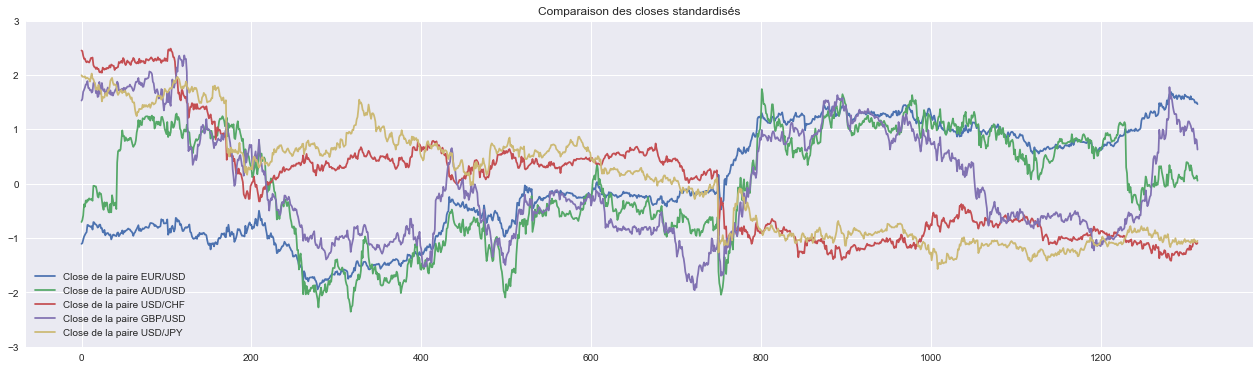

In [5]:
plt.figure(figsize=(22,6))

for pair in PAIR:
    name = isname(pair)

    #plt.figure(figsize=(16,4))
    plt.ylim(-3, 3)
    plt.title(label='Comparaison des closes standardisés')
    plt.plot(preprocessing.scale(pair['Close']),label='Close de la paire '+name,)
    plt.legend()

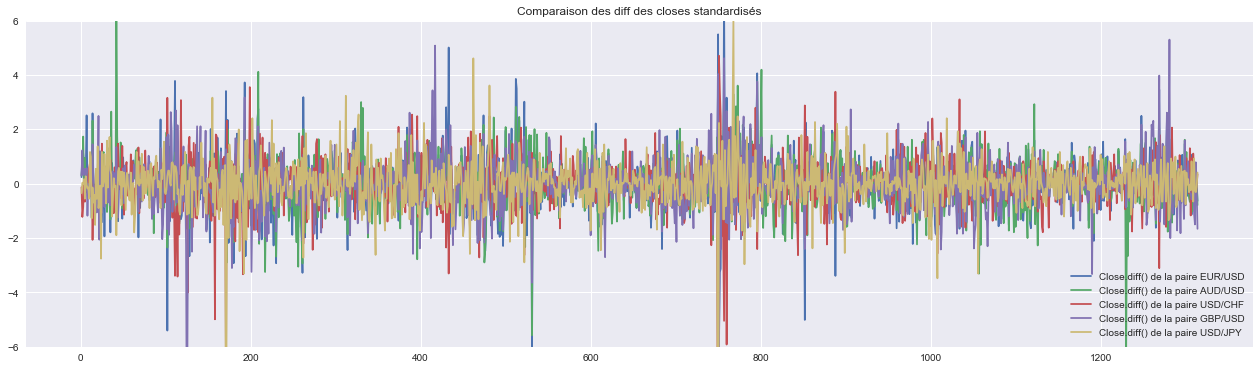

In [6]:
plt.figure(figsize=(22,6))

for pair in PAIR:
    name = isname(pair)

    #plt.figure(figsize=(16,4))
    plt.ylim(-6, 6)
    plt.title(label='Comparaison des diff des closes standardisés')
    plt.plot(preprocessing.scale(pair['Close'].diff()),label='Close.diff() de la paire '+name,)
    plt.legend()

EUR/USD :                                   OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.755
Method:                 Least Squares   F-statistic:                              4050.
Date:                Thu, 27 Feb 2020   Prob (F-statistic):                        0.00
Time:                        23:58:52   Log-Likelihood:                         -1430.4
No. Observations:                1315   AIC:                                      2863.
Df Residuals:                    1314   BIC:                                      2868.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

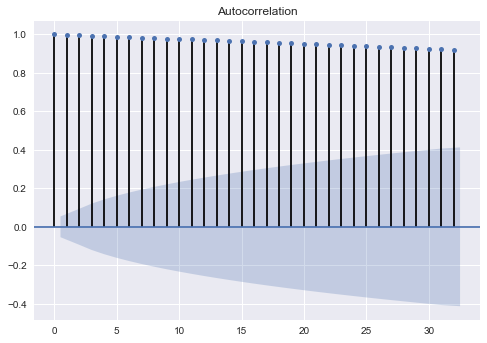

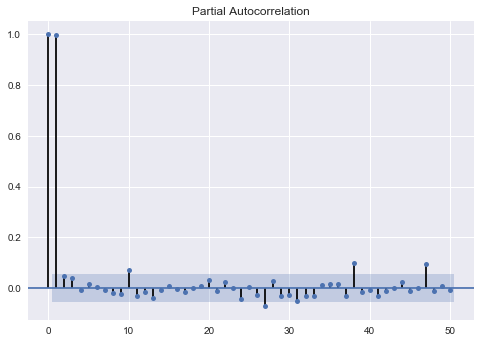

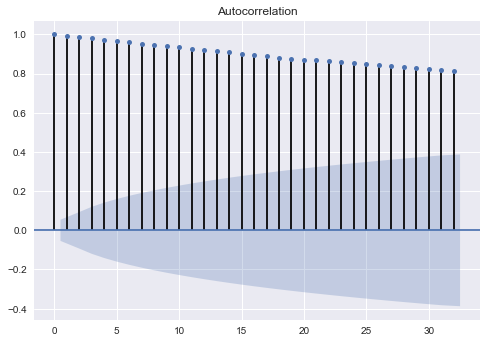

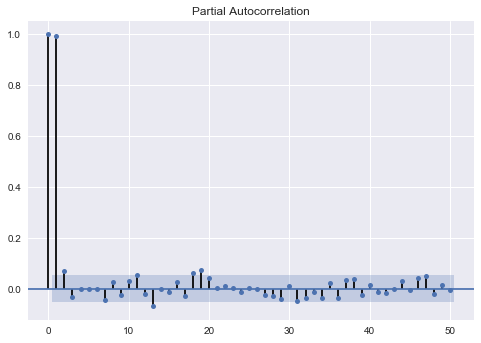

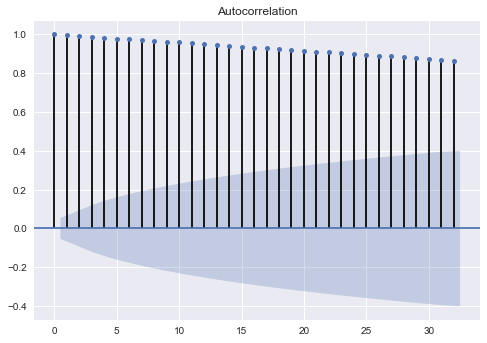

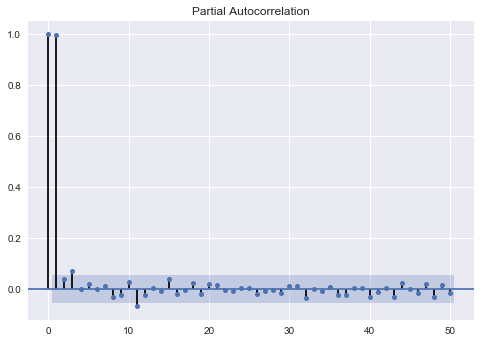

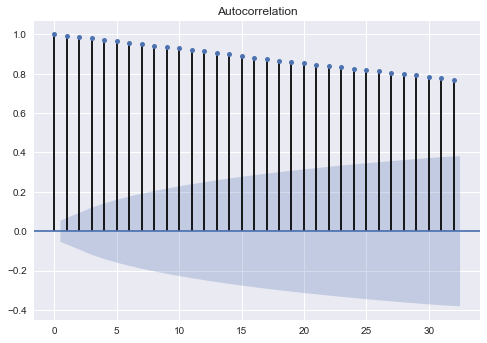

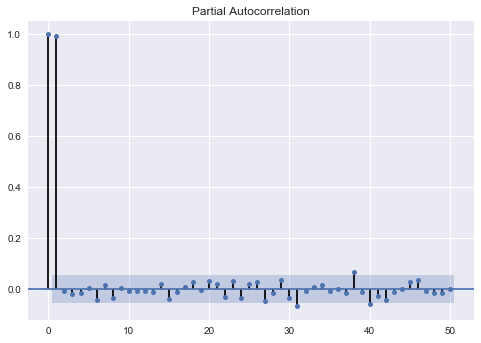

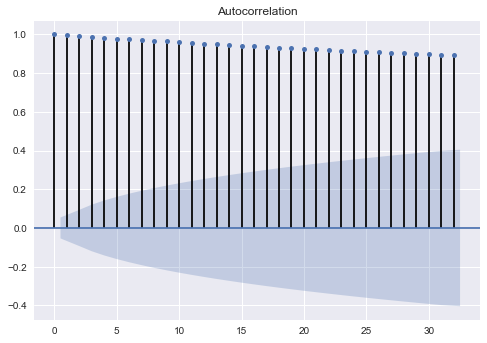

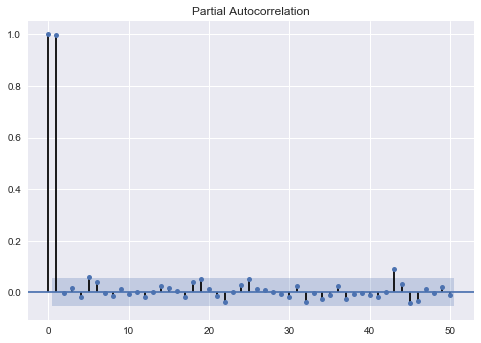

In [7]:
for pair in PAIR:
    
    name = isname(pair)
    
    model = sm.OLS(pair['Close'],pair.index)
    results = model.fit()
    residuals = results.resid
    summary = results.summary()

    jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)
    
    print(Fore.YELLOW,'POUR LA PAIRE '+name,Style.RESET_ALL)
    jarque_berra(pair)
    skewness(pair)
    kurtos(pair)
    autocor(pair)
    

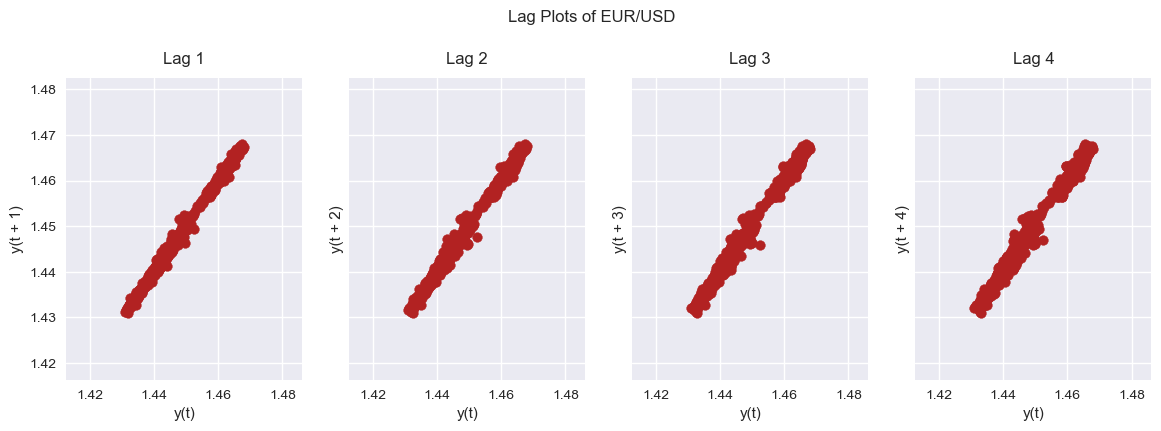

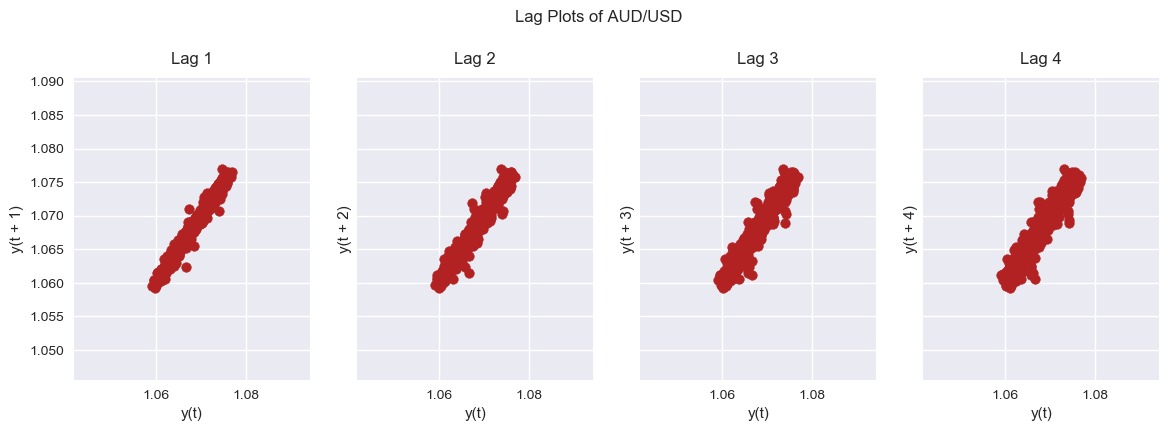

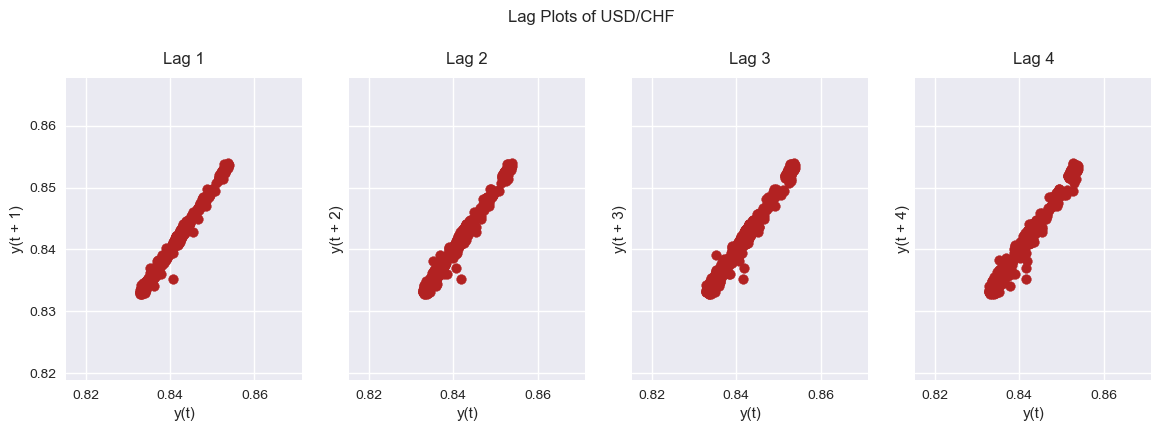

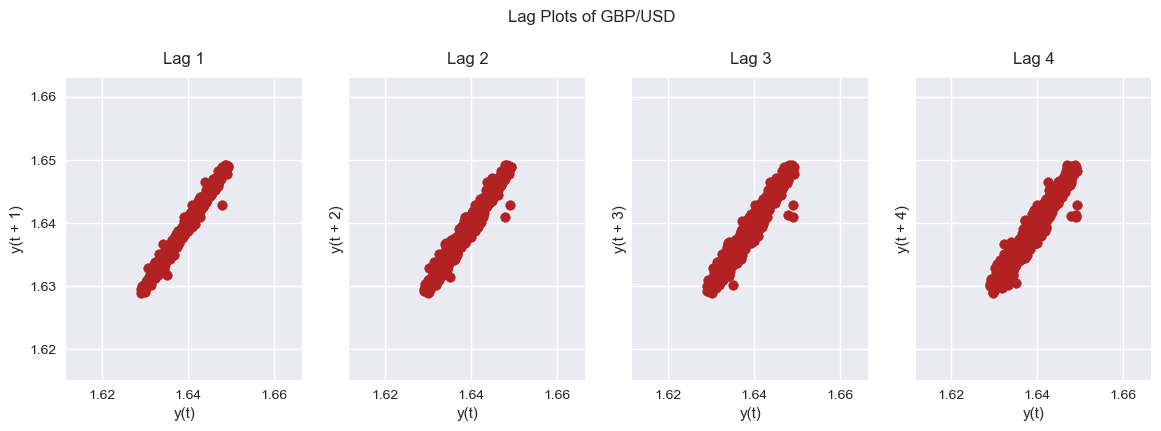

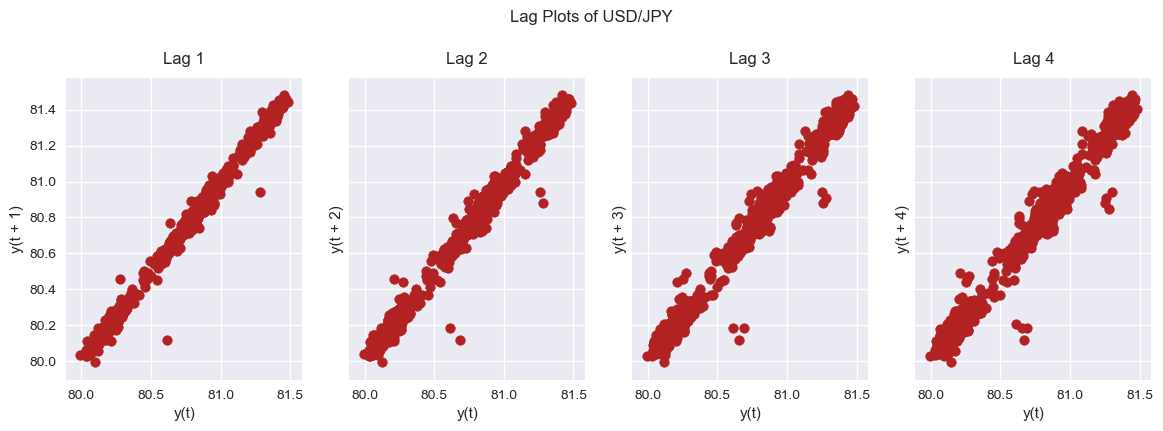

In [8]:
for pair in PAIR:
    name = isname(pair)
    plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

    ss = pair[['Local time','Close']]
    #ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(14,4), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()):
        lag_plot(ss.Close, lag=i+1, ax=ax, c='firebrick')
        ax.set_title('Lag ' + str(i+1))

    fig.suptitle('Lag Plots of '+name+' Closes \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    


    fig.suptitle('Lag Plots of '+name, y=1.05)    
    plt.show()

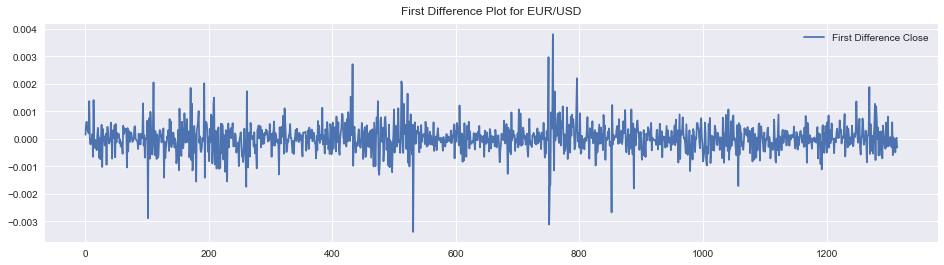

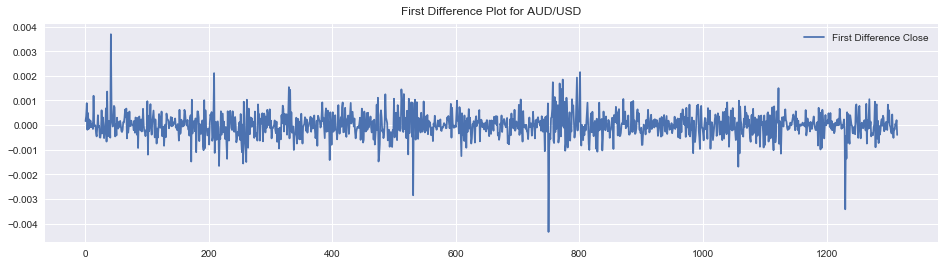

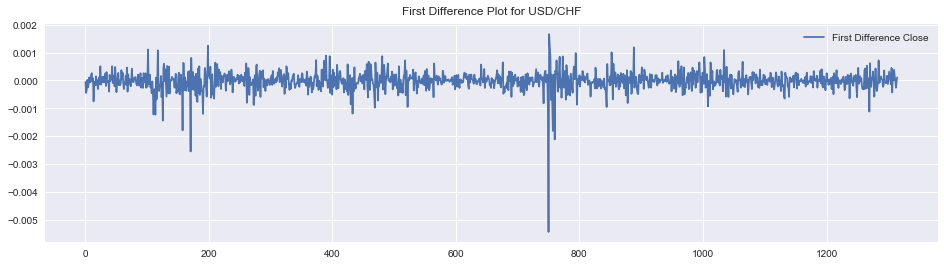

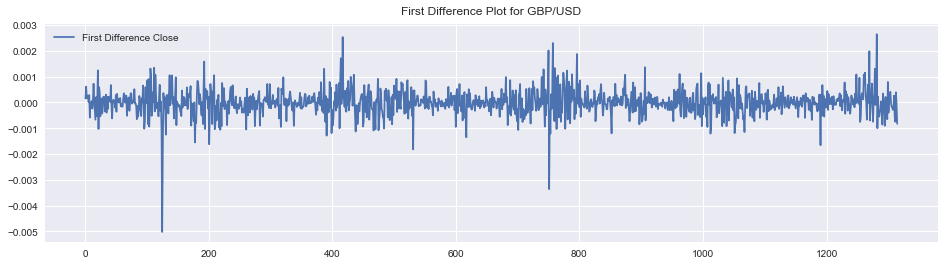

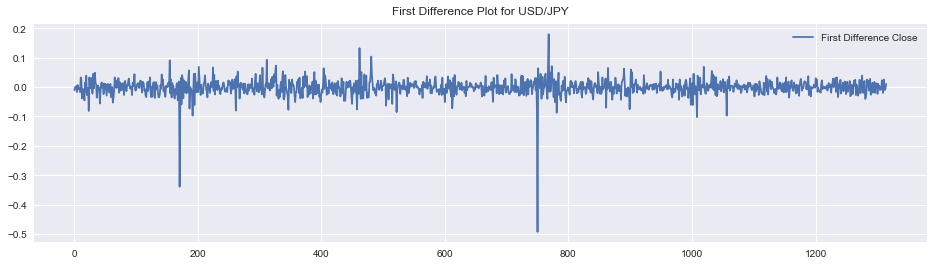

In [9]:
for pair in PAIR:
    name = isname(pair)
    diff = pair.Close.diff()
    plt.figure(figsize=(16,4))
    plt.plot(diff,label='First Difference Close')
    plt.title(label='First Difference Plot for '+name)
    plt.legend()



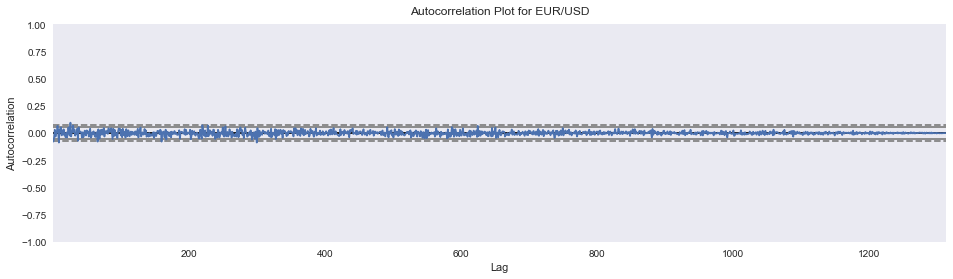

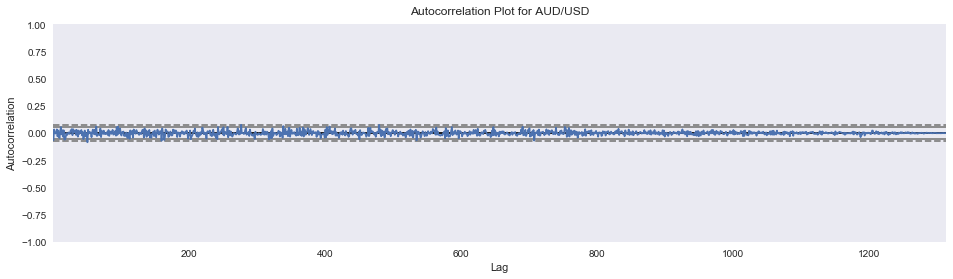

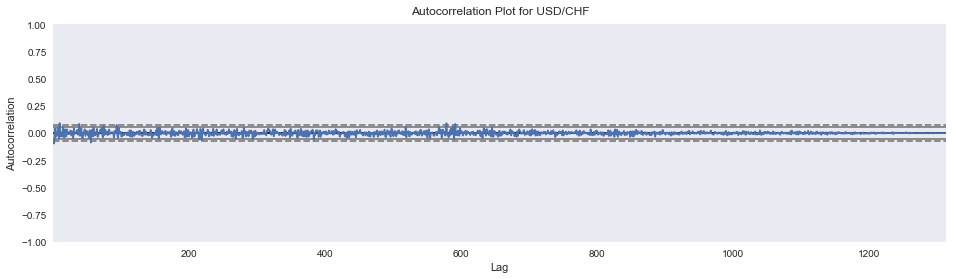

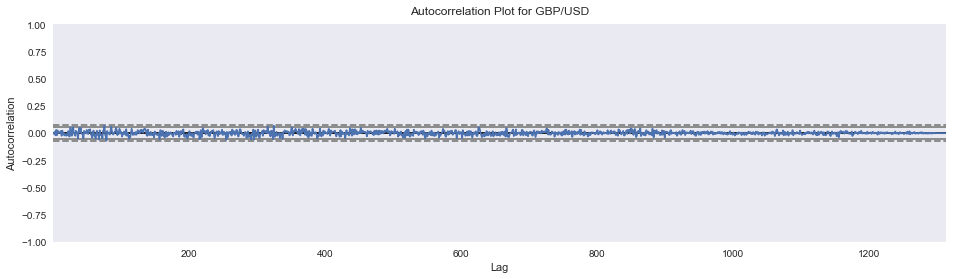

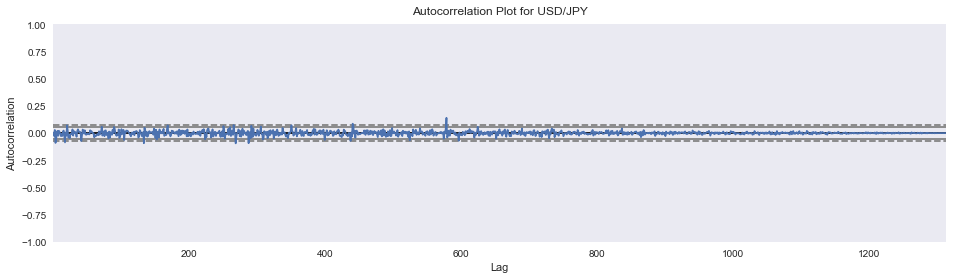

In [10]:
for pair in PAIR:
    name = isname(pair)
    diff = pair.Close.diff()
    plt.figure(figsize=(16,4))

    pd.plotting.autocorrelation_plot(diff[1:])
    plt.title(label='Autocorrelation Plot for '+name)
    

In [11]:
'''for pair in PAIR:
    name = isname(pair)
    timeseries = pair['Close']
    timeseries.index = pair['Local time']
    test_stationarity(timeseries)'''

"for pair in PAIR:\n    name = isname(pair)\n    timeseries = pair['Close']\n    timeseries.index = pair['Local time']\n    test_stationarity(timeseries)"

In [12]:
df = pd.DataFrame()
for pair in PAIR:
    name = isname(pair)
    df[name] = list(pair['Close'])
df.corr().style.background_gradient(cmap='coolwarm')

,EUR/USD,AUD/USD,USD/CHF,GBP/USD,USD/JPY
EUR/USD,1.000000,0.655231,-0.783704,0.285670,-0.862882
AUD/USD,0.655231,1.000000,-0.278279,0.667965,-0.396003
USD/CHF,-0.783704,-0.278279,1.000000,0.148600,0.924662
GBP/USD,0.285670,0.667965,0.148600,1.000000,0.108274
USD/JPY,-0.862882,-0.396003,0.924662,0.108274,1.000000


In [13]:
INTEGRE = []
for col in range(1,len(df.corr())):
    for ind in range(col):
        if df.corr().iloc[ind,col] > 0.5 and df.corr().iloc[ind,col] != 1:
            INTEGRE.append((df.corr().index[ind],df.corr().columns[col]))
        
INTEGRE  = list(set(INTEGRE))
print('Les paires ',INTEGRE,' sont correlées et permettent un factorisation.')

Les paires  [('EUR/USD', 'AUD/USD'), ('USD/CHF', 'USD/JPY'), ('AUD/USD', 'GBP/USD')]  sont correlées et permettent un factorisation.


In [14]:
kmo_all,kmo_model=calculate_kmo(df)
print('Le KMO du modèle est de :',kmo_model)
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    if kmo_all[loop] >= 0.6:
        print(Fore.GREEN,name,Style.RESET_ALL,' a un kmo considéré comme ',Fore.GREEN,'adéquet',Style.RESET_ALL)
    else:
        print(Fore.RED,name,Style.RESET_ALL,' a un kmo donsidéré comme ',Fore.RED,'inadéquat',Style.RESET_ALL)

Le KMO du modèle est de : 0.6553245668255875
 EUR/USD   a un kmo considéré comme   adéquet 
 AUD/USD   a un kmo considéré comme   adéquet 
 USD/CHF   a un kmo considéré comme   adéquet 
 GBP/USD   a un kmo donsidéré comme   inadéquat 
 USD/JPY   a un kmo considéré comme   adéquet 


/opt/anaconda3/envs/FinTech/lib/python3.7/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


In [15]:
chi_square_value,p_value=calculate_bartlett_sphericity(df)
print('Dans le test de Barlett, on ibserve un chi2 à ',chi_square_value,' et une p_value à', p_value)
if p_value < 0.05:
    print(Fore.GREEN,'Statistically significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée n'est pas une identity matrix" )
else:
    print(Fore.RED,'Statistically non significant',Style.RESET_ALL," ce qui signifie que la matrice de correlation observée peut être une identity matrix" )

Dans le test de Barlett, on ibserve un chi2 à  7068.716094050022  et une p_value à 0.0
 Statistically significant   ce qui signifie que la matrice de correlation observée n'est pas une identity matrix


In [16]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df)
print(fa.loadings_)
#fa.analyze(df, 25, rotation=None)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

[[ 0.95483536  0.06740894 -0.04848185]
 [ 0.65213089  0.62206369  0.19341221]
 [-0.84410745  0.40523349  0.10396035]
 [ 0.22859852  0.8841347  -0.16079847]
 [-0.93115388  0.35448778 -0.04797715]]


In [17]:
ev

array([3.04738219, 1.59116335, 0.21846134, 0.09956505, 0.04342807])

In [18]:
v

array([ 2.96881128e+00,  1.46307934e+00,  7.87258763e-02,  4.12634976e-06,
       -1.15415268e-05])

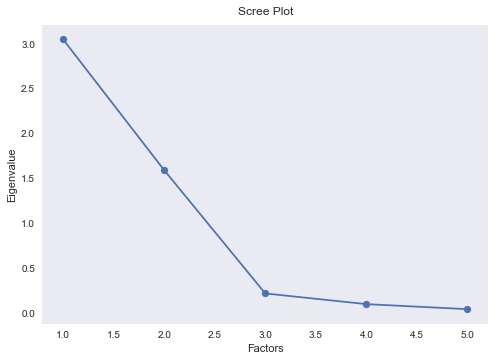

In [19]:
# Create scree plot using matplotlib
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [20]:
PRINCIPAL_COMPOSANT = []
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    print('\r\n'+name+' : ',ev[loop]," ===> ",end='')
    if ev[loop] >= 1:
        print('On garde le facteur car >1')
        PRINCIPAL_COMPOSANT.append((name,ev[loop]))
    else:
        print('On retire le facteur car <1')

print('\nRésumé des composants principaux gardés :')        
PRINCIPAL_COMPOSANT        


EUR/USD :  3.047382192907407  ===> On garde le facteur car >1

AUD/USD :  1.5911633477376048  ===> On garde le facteur car >1

USD/CHF :  0.21846133700028275  ===> On retire le facteur car <1

GBP/USD :  0.099565053715406  ===> On retire le facteur car <1

USD/JPY :  0.043428068639299135  ===> On retire le facteur car <1

Résumé des composants principaux gardés :


[('EUR/USD', 3.047382192907407), ('AUD/USD', 1.5911633477376048)]

In [21]:
pca = PCA(n_components=2)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [22]:
x_pca = pca.transform(df)
x_pca.shape

(1315, 2)

Text(0, 0.5, 'Second Principal Component')

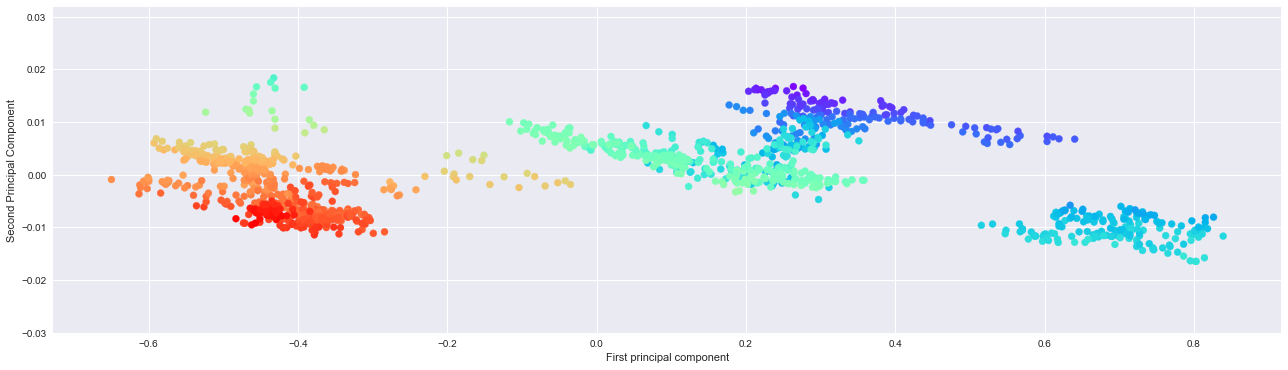

In [23]:
plt.figure(figsize=(22,6))
plt.scatter( x_pca[:,0],x_pca[:,1],c=df['EUR/USD'],cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [24]:
for loop,pair in enumerate(PAIR):
    name = isname(pair)
    print(name,' : ',pca.components_[0][loop],' - ',pca.components_[1][loop])
    

EUR/USD  :  -0.021264629775205983  -  -0.6505598794372663
AUD/USD  :  -0.004137872756399332  -  -0.47154233191182954
USD/CHF  :  0.012076995331806804  -  -0.045290908003773465
GBP/USD  :  0.0012243400611463861  -  -0.593428757988032
USD/JPY  :  0.9996916228041253  -  -0.01451603687991537


In [25]:
jh_results = johasen(df,0,1)
print('\nTrace Statistisque \n',jh_results.lr1)                           # dim = (n,) Trace statistic
print('\n\nCritical Value \n',jh_results.cvt)                           # dim = (n,3) critical value table (90%, 95%, 99%)
print('\n\nEigein Velue ec \n',jh_results.evec)                          # dim = (n, n), columnwise eigen-vectors
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]
print('\n\nProbabilité de Eigein \n',jh_results.eig)
if jh_results.eig[0] <= 0.05:
    print('\nTest de cointiégration de Johasen ',Fore.GREEN,'VALIDE!',Style.RESET_ALL)
else:
    print('\nTest de cointiégration de Johasen',Fore.RED,'INVALIDE!',Style.RESET_ALL)


Trace Statistisque 
 [70.41342645 42.58444962 23.04745133  8.268582    1.40699071]


Critical Value 
 [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


Eigein Velue ec 
 [[ 190.08147415  129.53468676  146.0642296  -108.45065849   87.60984373]
 [ 191.78990365 -338.10058842 -179.46001737  -28.14403158    5.32056426]
 [-278.96952851  -38.52518702  154.18381339 -387.30741121   79.85807744]
 [-297.23199898   27.79583697  117.5002979   231.91593306   21.16618076]
 [   8.85456089    1.23219606    1.62950723    1.92415376   -1.06809431]]


Probabilité de Eigein 
 [0.02097192 0.01476951 0.01119269 0.00521226 0.00107101]

Test de cointiégration de Johasen   VALIDE! 


In [26]:
X = df.iloc[:,1:]
y = df.iloc[:,0]
reg = LinearRegression().fit(X, y)
score = reg.score(X, y) *100
coef = reg.coef_
cste = reg.intercept_

if score > 70:
    print('Test ',Fore.GREEN,'VALIDE',Style.RESET_ALL,' avec un score de ',Fore.GREEN,score,Style.RESET_ALL,' %')
    print("Les poids respectifs sont de :")
    loop = -1
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)

elif score > 50:
    print('Test ',Fore.YELLOW,'MITIGE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,score,Style.RESET_ALL,' %')
    print("Les poids respectifs sont de :")
    loop = 0
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)

else:
    print('Test ',Fore.RED,'NON VALIDE',Style.RESET_ALL,' avec un score de ',Fore.YELLOW,score,Style.RESET_ALL,' %')
    print("Les poids respectifs sont de :")
    loop = 0
    for pair in PAIR:
        name = isname(pair)
        if name == 'EUR/USD':
            continue
        loop += 1
        print(name,' : ',coef[loop])
    print('Et la constante est : ',cste)


Test   VALIDE   avec un score de   89.59081867112904   %
Les poids respectifs sont de :
AUD/USD  :  0.3211539668385872
USD/CHF  :  -0.15403266840280652
GBP/USD  :  0.6300071590766148
USD/JPY  :  -0.01885129618525631
Et la constante est :  1.7249640665491006


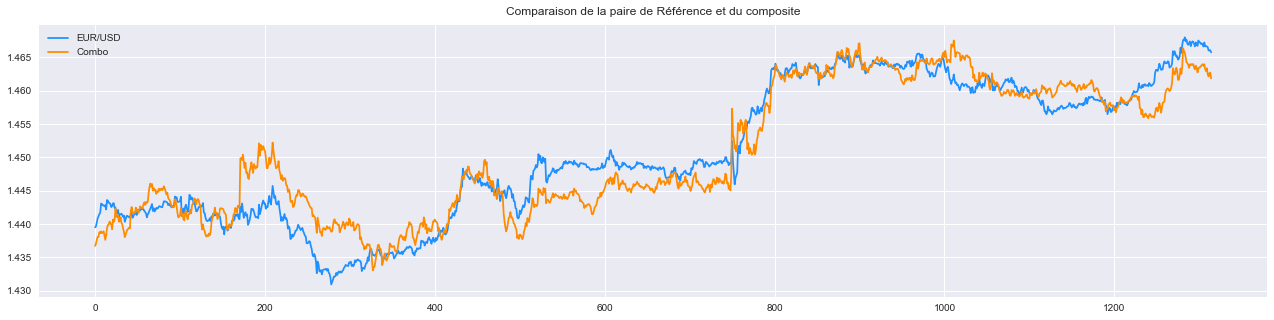

In [27]:
combo = cste + coef[0] * df['AUD/USD'] + coef[1] * df['USD/CHF'] + coef[2] * df['GBP/USD'] + coef[3] * df['USD/JPY']
plt.figure(figsize=(22,5))
plt.plot(df['EUR/USD'],label = 'EUR/USD',c='dodgerblue')
plt.plot(combo,label = 'Combo',c='darkorange')
plt.title('Comparaison de la paire de Référence et du composite')
plt.legend()

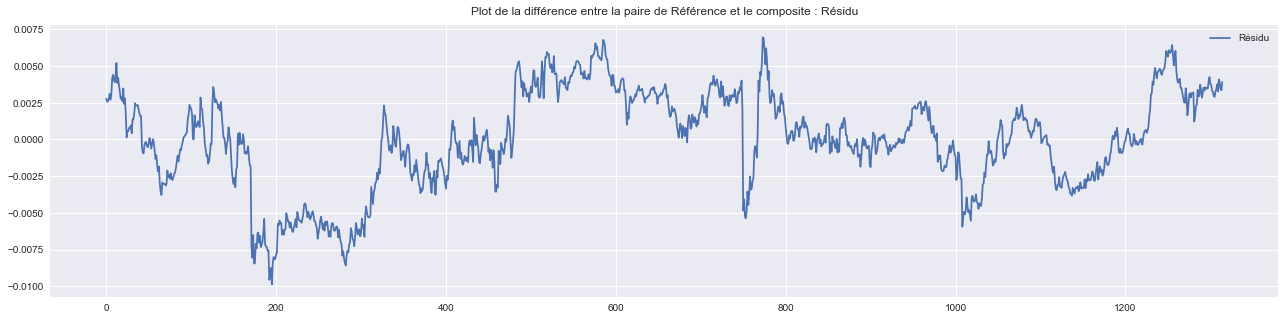

In [28]:
########
### RESIDUS
########
residu = df['EUR/USD']-combo
S = (residu - residu.mean())/residu.std()
plt.figure(figsize=(22,5))
plt.plot(residu,label = 'Résidu')
plt.title('Plot de la différence entre la paire de Référence et le composite : Résidu')
plt.legend()

 
TEST DE NORMALITE : JARQUE-BERA USD/JPY 
Puisque la p-value ( 0.0 ) de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on  refuse l’hypothèse de la normalité de la série 
 TEST JARQUE-BERRA VALIDE 
 
TEST D'ASSYMETRIE: SKEWNESS USD/JPY 
 /!\ ATTENTION SUPISCION DE NORMALITE /!\ 
 TEST SKEWNESS ECHOUE 
 
TEST D'ASSYMETRIE: KURTOSIS USD/JPY 
Puisque le skewness ( -1.2043 ) de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE
 TEST DE KURTOSIS VALIDE 
 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE USD/JPY 
USD/JPY :          ACF      PACF        QSTAT           PROB
0  1.000000  1.000000  1266.323524  2.353240e-277
1  0.980199  0.980945  2486.035107   0.000000e+00
2  0.961624  0.022134  3662.541050   0.000000e+00
3  0.944079  0.018533  4789.394864   0.000000e+00
4  0.923590 -0.085934  5871.681705   0.000000e+00
L'index de sortie de l'intervalle de confiance à 5% est de 2 . Il apparait donc clairement que la série n'es

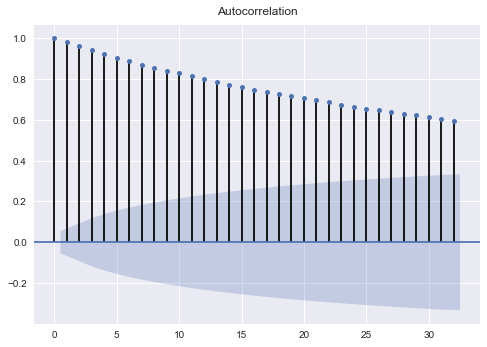

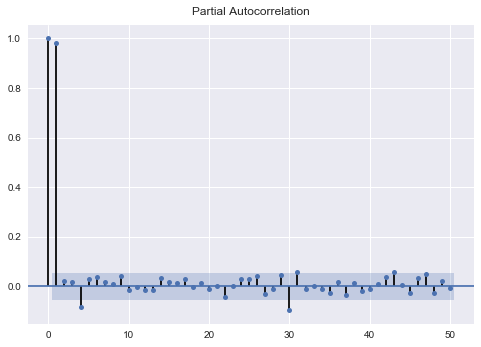

In [29]:
####
## ANALYSE DES RESIDUS
###

jarque_berra(residu)
skewness(residu)
kurtos(residu)
residu_autocor = pd.DataFrame()
residu_autocor['Close'] = residu.iloc[:]
autocor(residu_autocor)
print("La moyenne des résidus est de ",residu.mean(),", et leur ecart-type vaut ",residu.std())

In [30]:
model = sm.OLS(residu,residu.index)
results = model.fit()
residuals = results.resid
summary = results.summary()
name = 'Analyse des Résidus'
jb,p_value,skew,kurtosis,durbinwatson = ols(model,results, residuals)

Analyse des Résidus :                                   OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              22.03
Date:                Thu, 27 Feb 2020   Prob (F-statistic):                    2.97e-06
Time:                        23:59:00   Log-Likelihood:                          5661.5
No. Observations:                1315   AIC:                                 -1.132e+04
Df Residuals:                    1314   BIC:                                 -1.132e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE Analyse des Résidus 
Analyse des Résidus :          ACF      PACF        QSTAT           PROB
0  1.000000  1.000000  1266.323524  2.353240e-277
1  0.980199  0.980945  2486.035107   0.000000e+00
2  0.961624  0.022134  3662.541050   0.000000e+00
3  0.944079  0.018533  4789.394864   0.000000e+00
4  0.923590 -0.085934  5871.681705   0.000000e+00
L'index de sortie de l'intervalle de confiance à 5% est de 2 . Il apparait donc clairement que la série n'est pas un bruit blanc
 TEST AUTOCORRELATION VALIDE 


()

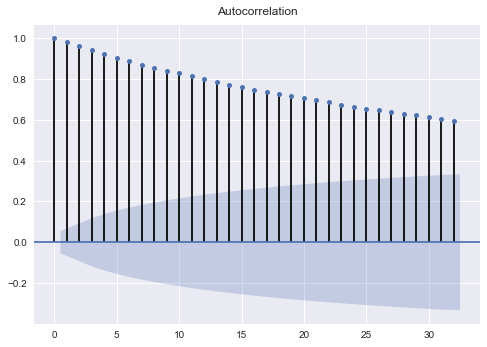

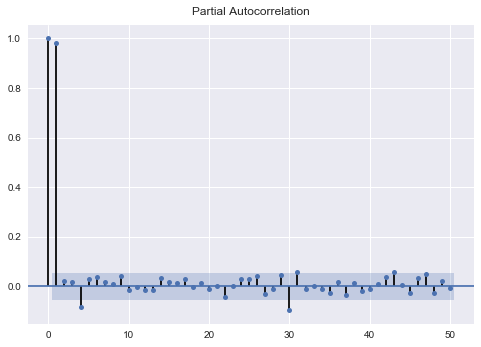

In [31]:
temp = pd.DataFrame()
temp['Close'] = residu.iloc[:]
autocor(temp)

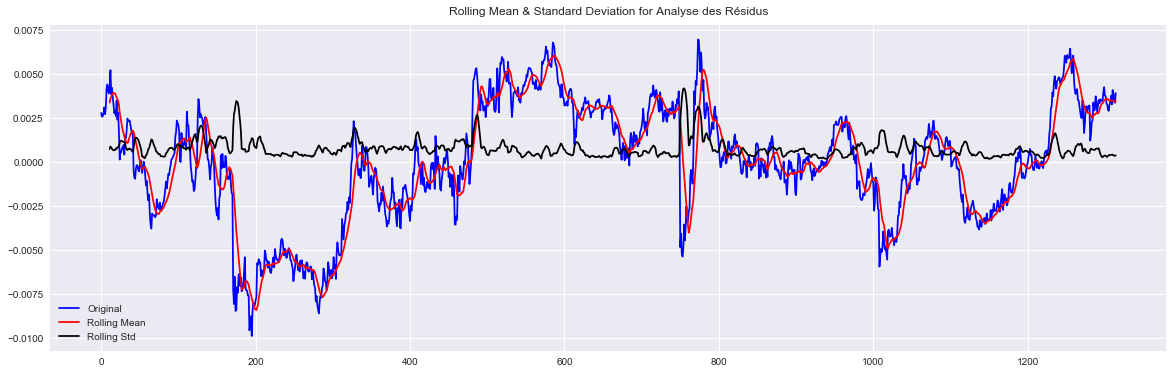

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                   -3.409258
p-value                           0.010647
#Lags Used                        1.000000
Number of Observations Used    1313.000000
Critical Value (1%)              -3.435340
Critical Value (5%)              -2.863744
Critical Value (10%)             -2.567943
dtype: float64
Le test est   VALIDE  et le résidu est :   STATIONNAIRE 


In [32]:
dfoutput =  test_stationarity(residu,lag = 1)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)

   

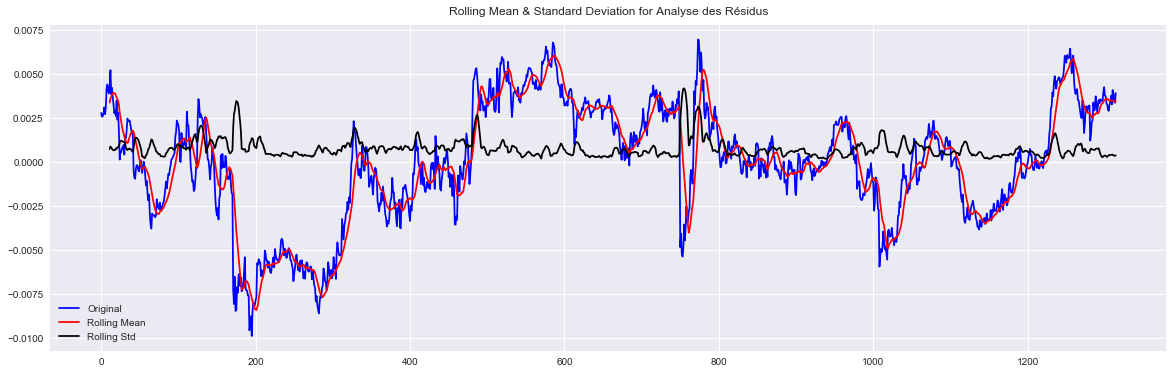

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                   -3.498642
p-value                           0.008022
#Lags Used                        0.000000
Number of Observations Used    1314.000000
Critical Value (1%)              -3.435336
Critical Value (5%)              -2.863742
Critical Value (10%)             -2.567942
dtype: float64
Le test est   VALIDE  et il y a un   RETOUR A LA MOYENNE 


In [33]:
#######
### RETOUR A LA MOYENNE
#######
dfoutput =  test_stationarity(residu,lag = 0)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a un ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)


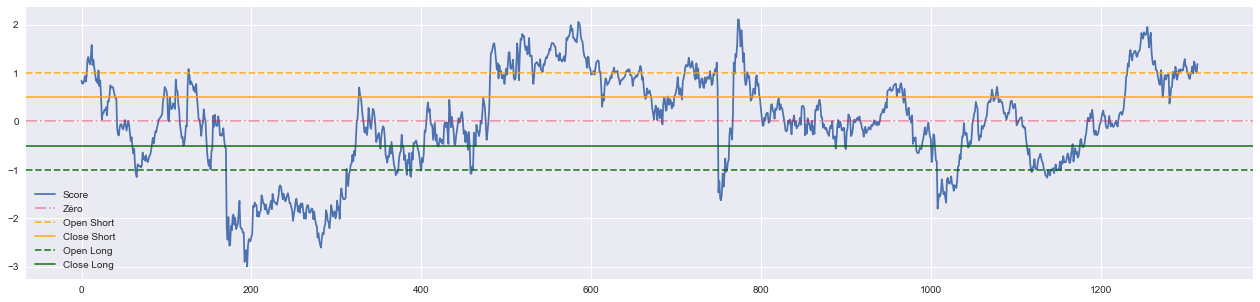

In [34]:
plt.figure(figsize=(22,5))
plt.plot(S,label='Score')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.legend()

In [35]:
########
### BT
#######


bt_eurusd = pd.read_csv('BT/EURUSD.csv')
#bt_eurusd.index = bt_eurusd['Local time']
#bt_eurusd = bt_eurusd.drop(['Local time'],axis=1)
bt_eurusd = bt_eurusd[(bt_eurusd['Local time'] >= '07.06.2011 13:35:00.000 GMT+0200')&(bt_eurusd['Local time'] <= '08.06.2011 11:00:00.000 GMT+0200')]
try:
    bt_eurusd = bt_eurusd.drop(['Unnamed: 0'],axis=1)
except:
    pass


bt_audusd = pd.read_csv('BT/AUDUSD.csv')
#bt_audusd.index = bt_audusd['Local time']
#bt_audusd = bt_audusd.drop(['Local time'],axis=1)
bt_audusd = bt_audusd[(bt_audusd['Local time'] >= '07.06.2011 13:35:00.000 GMT+0200')&(bt_audusd['Local time'] <= '08.06.2011 11:00:00.000 GMT+0200')]
try:
    bt_audusd = bt_audusd.drop(['Unnamed: 0'],axis=1)
except:
    pass


bt_usdchf = pd.read_csv('BT/USDCHF.csv')
#bt_chfusd.index = bt_chfusd['Local time']
#bt_chfusd = bt_chfusd.drop(['Local time'],axis=1)
bt_usdchf = bt_usdchf[(bt_usdchf['Local time'] >= '07.06.2011 13:35:00.000 GMT+0200')&(bt_usdchf['Local time'] <= '08.06.2011 11:00:00.000 GMT+0200')]
try:
    bt_usdchf = bt_usdchf.drop(['Unnamed: 0'],axis=1)
except:
    pass


bt_gbpusd = pd.read_csv('BT/GBPUSD.csv')
#bt_gbpusd.index = bt_gbpusd['Local time']
#bt_gbpusd = bt_gbpusd.drop(['Local time'],axis=1)
bt_gbpusd = bt_gbpusd[(bt_gbpusd['Local time'] >= '07.06.2011 13:35:00.000 GMT+0200')&(bt_gbpusd['Local time'] <= '08.06.2011 11:00:00.000 GMT+0200')]
try:
    bt_gbpusd = bt_gbpusd.drop(['Unnamed: 0'],axis=1)
except:
    pass

bt_usdjpy = pd.read_csv('BT/USDJPY.csv')
#bt_jpyusd.index = bt_jpyusd['Local time']
#bt_jpyusd = bt_jpyusd.drop(['Local time'],axis=1)
bt_usdjpy = bt_usdjpy[(bt_usdjpy['Local time'] >= '07.06.2011 13:35:00.000 GMT+0200')&(bt_usdjpy['Local time'] <= '08.06.2011 11:00:00.000 GMT+0200')]
try:
    bt_usdjpy = bt_usdjpy.drop(['Unnamed: 0'],axis=1)
except:
    pass

bt_PAIR = [bt_eurusd,bt_audusd,bt_usdchf,bt_gbpusd,bt_usdjpy]

In [36]:
bt_df = pd.DataFrame()
for bt_pair in bt_PAIR:
    
    if bt_pair.equals(bt_eurusd):
        name = 'EUR/USD'
    elif bt_pair.equals(bt_audusd):
        name = 'AUD/USD'
    elif bt_pair.equals(bt_usdchf):
        name = 'USD/CHF'
    elif bt_pair.equals(bt_gbpusd):
        name = 'GBP/USD'
    elif bt_pair.equals(bt_usdjpy):
        name = 'USD/JPY'
    
    
    bt_df[name] = list(bt_pair['Close'])
df.corr().style.background_gradient(cmap='coolwarm')

,EUR/USD,AUD/USD,USD/CHF,GBP/USD,USD/JPY
EUR/USD,1.000000,0.655231,-0.783704,0.285670,-0.862882
AUD/USD,0.655231,1.000000,-0.278279,0.667965,-0.396003
USD/CHF,-0.783704,-0.278279,1.000000,0.148600,0.924662
GBP/USD,0.285670,0.667965,0.148600,1.000000,0.108274
USD/JPY,-0.862882,-0.396003,0.924662,0.108274,1.000000


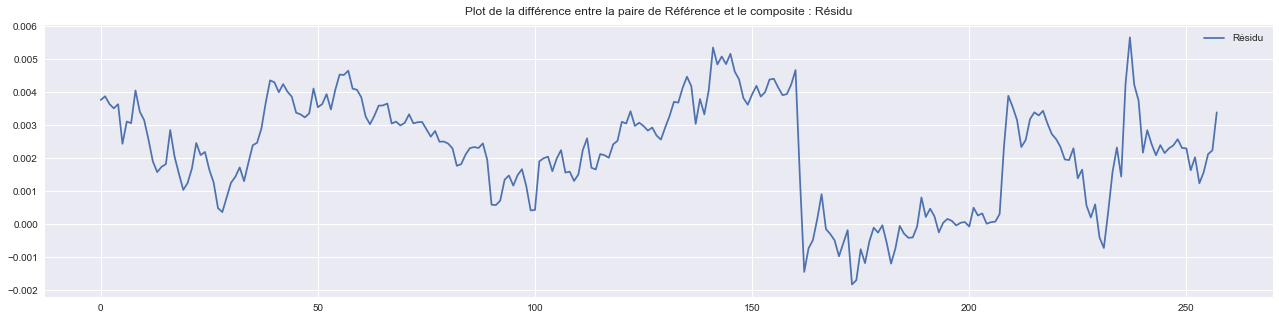

In [37]:
bt_combo = cste + coef[0] * bt_df['AUD/USD'] + coef[1] * bt_df['USD/CHF'] + coef[2] * bt_df['GBP/USD'] + coef[3] * bt_df['USD/JPY']
bt_residu = bt_df['EUR/USD']-bt_combo
bt_S = (bt_residu - bt_residu.mean())/bt_residu.std()
plt.figure(figsize=(22,5))
plt.plot(bt_residu,label = 'Résidu')
plt.title('Plot de la différence entre la paire de Référence et le composite : Résidu')
plt.legend()

 
TEST DE NORMALITE : JARQUE-BERA USD/JPY 
Puisque la p-value ( 0.0 ) de la statistique de Jarque-Bera est inférieure au seuil de signification de 5%, donc on  refuse l’hypothèse de la normalité de la série 
 TEST JARQUE-BERRA VALIDE 
 
TEST D'ASSYMETRIE: SKEWNESS USD/JPY 
Puisque le skewness ( -0.3813 ) de la statistiqest éloigné de 0, donc on valide en niveau 1 une distribution NON NORMALE
 TEST SKEWNESS VALIDE 
 
TEST D'ASSYMETRIE: KURTOSIS USD/JPY 
Puisque le skewness ( -0.3431 ) de la statistiqest éloigné de 3, donc on valide en niveau 2 une distribution NON NORMALE
 TEST DE KURTOSIS VALIDE 
 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE USD/JPY 
USD/JPY :          ACF      PACF       QSTAT           PROB
0  1.000000  1.000000  221.315438   4.671506e-50
1  0.920822  0.924405  402.025377   5.026881e-88
2  0.830452 -0.120884  553.814247  1.035544e-119
3  0.759615  0.091394  683.649298  1.209242e-146
4  0.701159  0.023340  800.451245  9.239925e-171
L'index de sortie de l'intervalle de

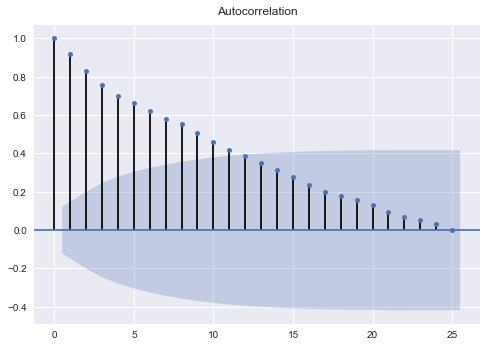

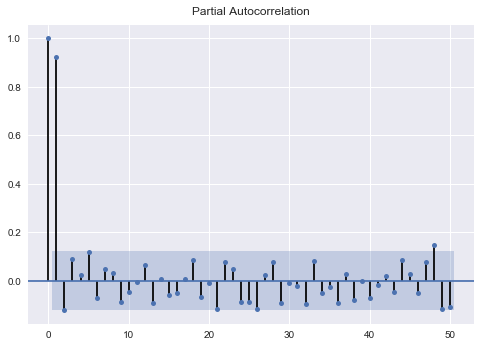

In [38]:
jarque_berra(bt_residu)
skewness(bt_residu)
kurtos(bt_residu)
bt_residu_autocor = pd.DataFrame()
bt_residu_autocor['Close'] = bt_residu.iloc[:]
autocor(bt_residu_autocor)
print("La moyenne des résidus est de ",bt_residu.mean(),", et leur ecart-type vaut ",bt_residu.std())

In [39]:
bt_model = sm.OLS(bt_residu,bt_residu.index)
bt_results = bt_model.fit()
bt_residuals = bt_results.resid
bt_summary = bt_results.summary()
name = 'Analyse des Résidus'
jb,p_value,skew,kurtosis,durbinwatson = ols(bt_model,bt_results, bt_residuals)

Analyse des Résidus :                                   OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.383
Model:                            OLS   Adj. R-squared (uncentered):              0.381
Method:                 Least Squares   F-statistic:                              159.6
Date:                Thu, 27 Feb 2020   Prob (F-statistic):                    8.84e-29
Time:                        23:59:03   Log-Likelihood:                          1222.2
No. Observations:                 258   AIC:                                     -2442.
Df Residuals:                     257   BIC:                                     -2439.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

 
CORRELOGRAMME D'AUTOCORRELATION DE LA PAIRE Analyse des Résidus 
Analyse des Résidus :          ACF      PACF       QSTAT           PROB
0  1.000000  1.000000  221.315438   4.671506e-50
1  0.920822  0.924405  402.025377   5.026881e-88
2  0.830452 -0.120884  553.814247  1.035544e-119
3  0.759615  0.091394  683.649298  1.209242e-146
4  0.701159  0.023340  800.451245  9.239925e-171
L'index de sortie de l'intervalle de confiance à 5% est de 3 . Il apparait donc clairement que la série n'est pas un bruit blanc
 TEST AUTOCORRELATION VALIDE 


()

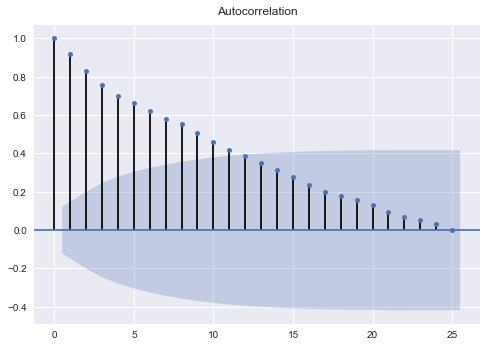

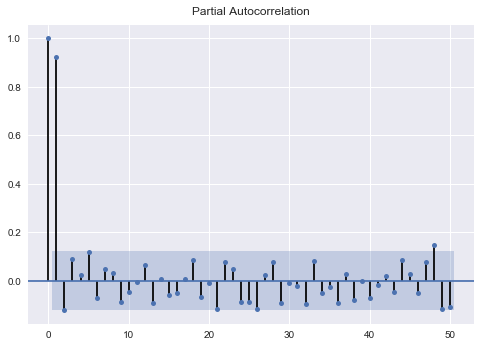

In [40]:
temp = pd.DataFrame()
temp['Close'] = bt_residu.iloc[:]
autocor(temp)

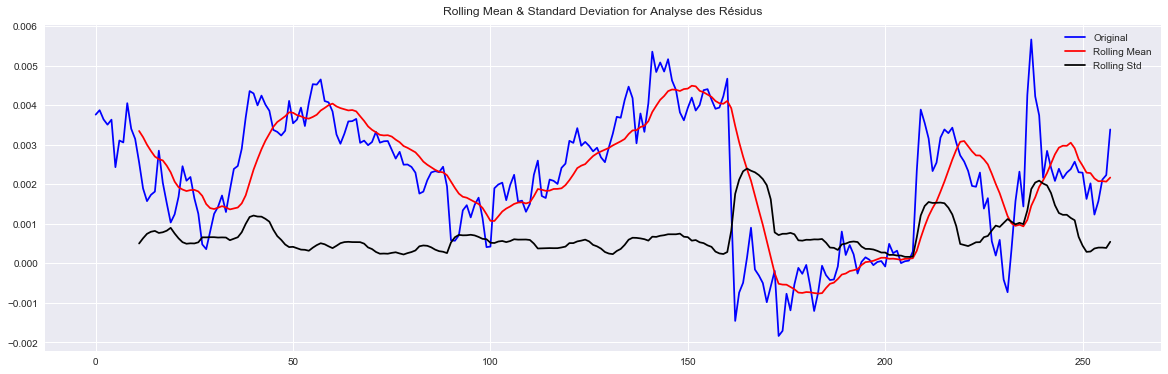

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -3.581705
p-value                          0.006121
#Lags Used                       1.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64
Le test est   VALIDE  et le résidu est :   STATIONNAIRE 


In [41]:
dfoutput =  test_stationarity(bt_residu,lag = 1)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et le résidu est : ',Fore.GREEN,'STATIONNAIRE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,'et le résidu  : ',Fore.RED,'NON STATIONNAIRE',Style.RESET_ALL)


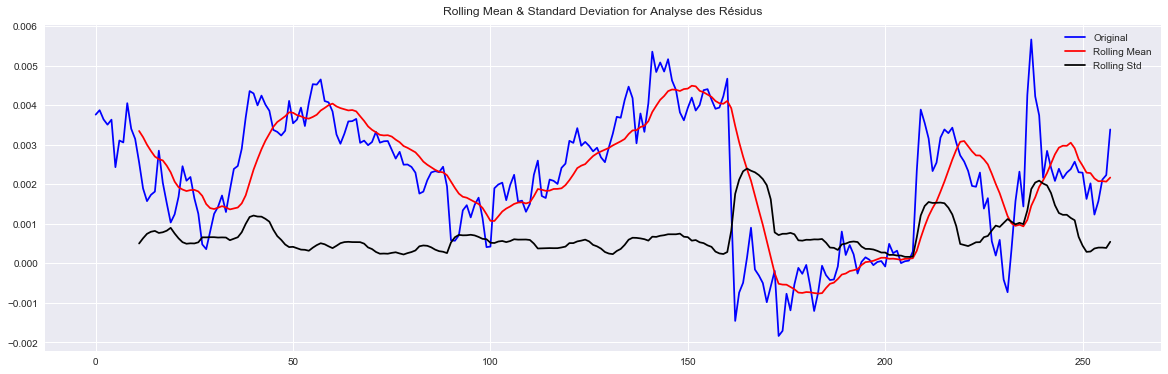

Results of Dickey-Fuller Test pour la paire : Analyse des Résidus
Test Statistic                  -3.215738
p-value                          0.019092
#Lags Used                       0.000000
Number of Observations Used    257.000000
Critical Value (1%)             -3.456054
Critical Value (5%)             -2.872853
Critical Value (10%)            -2.572799
dtype: float64
Le test est   VALIDE  et il y a :   RETOUR A LA MOYENNE 


In [42]:
#######
### RETOUR A LA MOYENNE
#######
dfoutput =  test_stationarity(bt_residu,lag = 0)
if dfoutput[1] < 0.05 and dfoutput[0] < dfoutput[6]:
    print('Le test est ',Fore.GREEN,'VALIDE',Style.RESET_ALL,'et il y a : ',Fore.GREEN,'RETOUR A LA MOYENNE',Style.RESET_ALL)
else:
    print('Le test est ',Fore.RED,'NON VALIDE',Style.RESET_ALL,"et il n'y a ",Fore.RED,'PAS RETOUR A LA MOYENNE',Style.RESET_ALL)

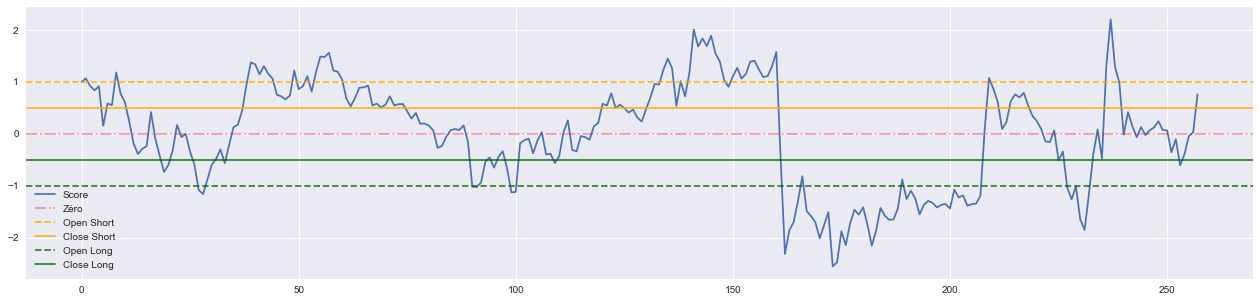

In [43]:
plt.figure(figsize=(22,5))
plt.plot(bt_S,label='Score')
plt.axhline(y=0,c='crimson',alpha=0.4,linestyle='-.',label='Zéro')
plt.axhline(y=1,c='orange',alpha=0.8,linestyle='--',label='Open Short')
plt.axhline(y=0.5,c='orange',alpha=0.8,label ='Close Short')
plt.axhline(y=-1,c='darkgreen',alpha=0.8,linestyle='--', label='Open Long')
plt.axhline(y=-0.5,c='darkgreen',alpha=0.8,label='Close Long')
plt.legend()

In [44]:
backtest_df = pd.DataFrame()
backtest_df = bt_df
backtest_df.index = bt_pair['Local time']
backtest_df['Spread'] = bt_residu.to_list()
backtest_df['Signals'] = bt_S.to_list()
backtest_df.tail()

,EUR/USD,AUD/USD,USD/CHF,GBP/USD,USD/JPY,Spread,Signals
Local time,,,,,,,
08.06.2011 10:40:00.000 GMT+0200,1.46451,1.06306,0.83657,1.63718,79.871,0.001236,-0.606491
08.06.2011 10:45:00.000 GMT+0200,1.46521,1.06336,0.83608,1.63766,79.877,0.001575,-0.391767
08.06.2011 10:50:00.000 GMT+0200,1.46528,1.06317,0.83635,1.63689,79.871,0.002119,-0.046692
08.06.2011 10:55:00.000 GMT+0200,1.46571,1.06332,0.83626,1.63675,79.853,0.002236,0.027341
08.06.2011 11:00:00.000 GMT+0200,1.46621,1.06314,0.83625,1.63676,79.885,0.003389,0.758041




Date :  07.06.2011 13:40:00.000 GMT+0200
 ACTION OPEN SHORT  - 
close EUR/USA  1.46645 
close AUD/USD :  1.07006 
Close USD/CHF :  0.83411 
Close GBP/USD :  1.64192 
Close USD/JPY :  80.206


Date :  07.06.2011 14:00:00.000 GMT+0200
 ACTION CLOSE SHORT  - 
close EUR/USA  1.4651299999999998 
close AUD/USD :  1.06971 
Close USD/CHF :  0.8347899999999999 
Close GBP/USD :  1.6421 
Close USD/JPY :  80.194
pnl EUR/USd : 132.0000000000291 
pnl au : -11.240388839352818 
pnl ch : -12.547133352567586 
pnl gp 11.340128863361315 
pnl jp : 0.2820853857185862 
total combo :  -12.165307942840501 
pnl total : 119.8346920571886


Date :  07.06.2011 14:15:00.000 GMT+0200
 ACTION OPEN SHORT  - 
close EUR/USA  1.46506 
close AUD/USD :  1.06942 
Close USD/CHF :  0.83544 
Close GBP/USD :  1.64155 
Close USD/JPY :  80.255


Date :  07.06.2011 14:30:00.000 GMT+0200
 ACTION CLOSE SHORT  - 
close EUR/USA  1.46589 
close AUD/USD :  1.07041 
Close USD/CHF :  0.8352700000000001 
Close GBP/USD :  1.64307999999999

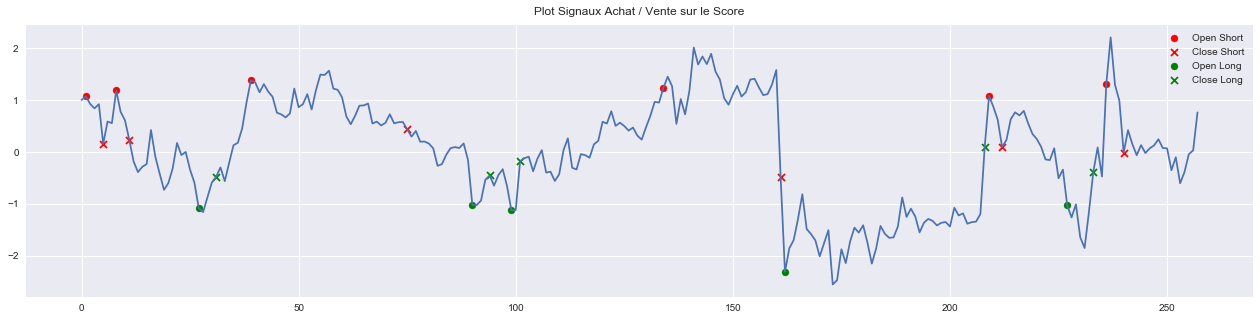

In [50]:
plt.figure(figsize=(22,5))
_plot = plt.plot(bt_S,label = 'Score')
os,cs,ol,cl = 0,0,0,0

mise = 100000
pactol = 100000
profit_long = 0
profit_short = 0
profit = 0
nbre_trade = 0
nbre_trade_long = 0
nbre_trade_short = 0

for mark in range(0,len(backtest_df)):
    if backtest_df.iloc[mark]['Signals'] > 1 and os == 0:
        _os = scatter =  plt.scatter(x=mark,y=bt_S[mark],c='r',marker='o',label='Open Short')
        os = 1
        cs = 0
        #pactol = pactol + mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol - mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['USD/CHF'] +\
                                 #coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['USD/JPY'])
        eos = mise * backtest_df.iloc[mark]['EUR/USD']
        auos = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chos = - mise * coef[1] * backtest_df.iloc[mark]['USD/CHF']
        gbos = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpos = - mise * coef[3] * backtest_df.iloc[mark]['USD/JPY']
        
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN SHORT',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose USD/CHF : ',backtest_df.iloc[mark]['USD/CHF'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose USD/JPY : ',backtest_df.iloc[mark]['USD/JPY'])  
    
    if backtest_df.iloc[mark]['Signals'] < 0.5 and os == 1:
        _cs = scatter = plt.scatter(x=mark,y=bt_S[mark],c='r',marker='x',label='Close Short : ')
        os = 0
        cs = 1
        #pactol = pactol - mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol + mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['USD/CHF'] +\
                                 #coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['USD/JPY'])
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE SHORT',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose USD/CHF : ',backtest_df.iloc[mark]['USD/CHF'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose USD/JPY : ',backtest_df.iloc[mark]['USD/JPY']) 
        
        #e = e - mise * backtest_df.iloc[mark]['EUR/USD']
        #au = au + mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        #ch = (ch +  mise * coef[1] * backtest_df.iloc[mark]['USD/CHF']) / backtest_df.iloc[mark]['USD/CHF']
        #gb = gb + mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        #jp = (jp + mise * coef[3] * backtest_df.iloc[mark]['USD/JPY']) / backtest_df.iloc[mark]['USD/JPY']
        
        ecs = - mise * backtest_df.iloc[mark]['EUR/USD']
        aucs = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcs = mise * coef[1] * backtest_df.iloc[mark]['USD/CHF']
        gbcs = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcs = mise * coef[3] * backtest_df.iloc[mark]['USD/JPY']
        
        pnles = eos + ecs
        pnlaus = auos + aucs
        pnlchs = (chos + chcs) / backtest_df.iloc[mark]['USD/CHF']
        pnlgbs = gbos + gbcs
        pnljps = (jpos + jpcs) / backtest_df.iloc[mark]['USD/JPY']
        pnlcombos = pnlaus + pnlchs + pnlgbs + pnljps
        pnls = pnles + pnlcombos
        
        nbre_trade += 1
        nbre_trade_short +=1
        
        profit = profit + pnls
        
        print('pnl EUR/USd :',pnles,'\npnl au :',pnlaus,'\npnl ch :',pnlchs,'\npnl gp',pnlgbs,'\npnl jp :',pnljps,\
              '\ntotal combo : ',pnlcombos,'\npnl total :',pnls)
        
        
    if backtest_df.iloc[mark]['Signals'] < -1 and ol == 0:
        _ol = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='o',label='Open Long')
        ol = 1
        os = 0
        #pactol = pactol - mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol + mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['USD/CHF'] +\
        #                         coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['USD/JPY'])
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.GREEN,'ACTION OPEN LONG',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose USD/CHF : ',backtest_df.iloc[mark]['USD/CHF'],'\nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose USD/JPY : ',backtest_df.iloc[mark]['USD/JPY'])
        
        eol = - mise * backtest_df.iloc[mark]['EUR/USD']
        auol = mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chol = mise * coef[1] * backtest_df.iloc[mark]['USD/CHF']
        gbol = mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpol = mise * coef[3] * backtest_df.iloc[mark]['USD/JPY']
        
        
        
    if backtest_df.iloc[mark]['Signals'] > -0.5 and ol == 1 :
        _cl = scatter = plt.scatter(x=mark,y=bt_S[mark],c='g',marker='x',label='Close Long')
        ol = 0
        cl = 1
        #pactol = pactol + mise * backtest_df.iloc[mark]['EUR/USD']
        #pactol = pactol - mise * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['USD/CHF'] +\
        #                         coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['USD/JPY'])
        
        print('\n\nDate : ',backtest_df.index[mark])
        print(Fore.RED,'ACTION CLOSE LONG',Style.RESET_ALL,\
              '- \nclose EUR/USA ',backtest_df.iloc[mark]['EUR/USD'],'\nclose AUD/USD : ',backtest_df.iloc[mark]['AUD/USD'],\
              '\nClose USD/CHF : ',backtest_df.iloc[mark]['USD/CHF'],' \nClose GBP/USD : ', backtest_df.iloc[mark]['GBP/USD'],\
             '\nClose USD/JPY : ',backtest_df.iloc[mark]['USD/JPY'])
        
        ecl = mise * backtest_df.iloc[mark]['EUR/USD']
        aucl = -  mise * coef[0] * backtest_df.iloc[mark]['AUD/USD']
        chcl = - mise * coef[1] * backtest_df.iloc[mark]['USD/CHF']
        gbcl = - mise * coef[2] * backtest_df.iloc[mark]['GBP/USD']
        jpcl = - mise * coef[3] * backtest_df.iloc[mark]['USD/JPY']
        
        pnlel = eol + ecl
        pnlaul = auol + aucl
        pnlchl = (chol + chcl) / backtest_df.iloc[mark]['USD/CHF']
        pnlgbl = gbol + gbcl
        pnljpl = (jpol + jpcl) / backtest_df.iloc[mark]['USD/JPY']
        pnlcombol = pnlaul + pnlchl + pnlgbl + pnljpl
        pnll = pnlel + pnlcombol
        
        nbre_trade += 1
        nbre_trade_long +=1
        
        profit = profit + pnll
        
        print('pnl EUR/USd :',pnlel,'\npnl au :',pnlaul,'\npnl ch :',pnlchl,'\npnl gp',pnlgbl,'\npnl jp :',pnljpl,\
              '\ntotal combo : ',pnlcombol,'\npnl total :',pnll)
        
        print('\n\nProfit en Long :',pnll)
        print('Profit en Short : ',pnls)


    
plt.title('Plot Signaux Achat / Vente sur le Score')
plt.legend((_os,_cs,_ol,_cl),('Open Short','Close Short','Open Long','Close Long'),scatterpoints=1 )

'''if ol == 1:
    pactol = pactol - qty * backtest_df.iloc[mark]['EUR/USD']
    pactol = pactol + qty * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['USD/CHF'] +\
                             coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['USD/JPY']) 
    
if os == 1:
    pactol = pactol + qty * backtest_df.iloc[mark]['EUR/USD']
    pactol = pactol - qty * (coef[0] * backtest_df.iloc[mark]['AUD/USD'] + coef[1] * backtest_df.iloc[mark]['USD/CHF'] +\
                             coef[2] * backtest_df.iloc[mark]['GBP/USD'] + coef[3] * backtest_df.iloc[mark]['USD/JPY'])'''
    
print(Fore.YELLOW,'------------------------------------------------------------------------')
print(' --------------------------------RESULTATS--------------------------------')
print(' ------------------------------------------------------------------------',Style.RESET_ALL)
if profit < 0:
    print('Le profit généré en $',Fore.RED,round(profit,2),Style.RESET_ALL)
    

if profit > 0:
    print('Le profit généré en $',Fore.GREEN,round(profit,2),Style.RESET_ALL)

print('Nombre de trades long : ',nbre_trade_long)
print('Nombre de trades short : ',nbre_trade_short)
    

In [51]:
backtest_df.index[mark]

'08.06.2011 11:00:00.000 GMT+0200'

In [52]:
coef[0],coef[1],coef[2],coef[3]

(0.3211539668385872,
 -0.15403266840280652,
 0.6300071590766148,
 -0.01885129618525631)